# Lesson 29: PyTorch CIFAR-10 classifier activity

In this activity, you will build a deep neural network classifier for the CIFAR-10 dataset using PyTorch. The data loading and preparation code is provided. Your task is to:

1. **Define the model** - Build a DNN using `nn.Sequential`
2. **Train the model** - Write a training loop with validation tracking
3. **Evaluate the model** - Assess performance on the test set

## Notebook set-up

### Imports

In [30]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)

from sklearn.preprocessing import label_binarize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


### Hyperparameters

In [32]:
batch_size = 2500 # Training images come in 5 batches of 10,000
learning_rate = 3e-3
epochs = 150
print_every = 10 # Print training progress every n epochs

## 1. Load and preprocess CIFAR-10 data

CIFAR-10 contains 32x32 color images across 10 classes. We convert the images to grayscale for this exercise.

### 1.1. Define transformations and class names

In [33]:
# Define class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Data preprocessing: convert to grayscale, tensor, and normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### 1.2. Load datasets

In [34]:
# Make sure data directory exists
data_dir = Path('./data')
data_dir.mkdir(parents=True, exist_ok=True)

# Load training and test datasets
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Number of classes: {len(class_names)}')

Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000
Image shape: torch.Size([1, 32, 32])
Number of classes: 10


### 1.3. Pre-load data and create data loaders

In [35]:
# Pre-load entire dataset to device for faster training
X_train_full = torch.stack([img for img, _ in train_dataset]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset]).to(device)

X_test = torch.stack([img for img, _ in test_dataset]).to(device)
y_test = torch.tensor([label for _, label in test_dataset]).to(device)

# Split training data into train and validation sets (80/20 split)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train = X_train_full[indices[:n_train]]
y_train = y_train_full[indices[:n_train]]
X_val = X_train_full[indices[n_train:]]
y_val = y_train_full[indices[n_train:]]

print(f'X_train shape: {X_train.shape}, device: {X_train.device}')
print(f'y_train shape: {y_train.shape}, device: {y_train.device}')
print(f'X_val shape: {X_val.shape}, device: {X_val.device}')
print(f'y_val shape: {y_val.shape}, device: {y_val.device}')
print(f'X_test shape: {X_test.shape}, device: {X_test.device}')
print(f'y_test shape: {y_test.shape}, device: {y_test.device}')

X_train shape: torch.Size([40000, 1, 32, 32]), device: cpu
y_train shape: torch.Size([40000]), device: cpu
X_val shape: torch.Size([10000, 1, 32, 32]), device: cpu
y_val shape: torch.Size([10000]), device: cpu
X_test shape: torch.Size([10000, 1, 32, 32]), device: cpu
y_test shape: torch.Size([10000]), device: cpu


In [36]:
# Create TensorDatasets
train_tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(
    train_tensor_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 16
Validation batches: 4
Test batches: 4


### 1.4. Visualize sample images

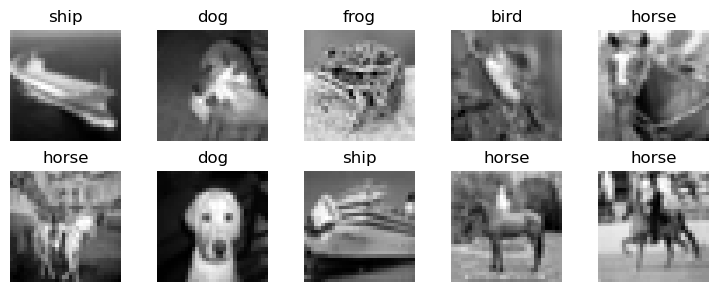

In [37]:
# Get a batch of training images
images, labels = next(iter(train_loader))

# Plot first 10 images
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):

    img = images[i].cpu() * 0.5 + 0.5
    img = img.numpy().squeeze()
    ax.set_title(class_names[labels[i]])
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 2. Build DNN classifier

### Task 1: Define model architecture

Build a fully connected neural network using `nn.Sequential` to classify CIFAR-10 images.

**Requirements:**
- Flatten the input images (32x32x1 = 1024 features)
- Use at least 2 hidden layers with ReLU activation
- Add dropout for regularization
- Output layer should have 10 units (one per class)

**Hints:**
- Use `nn.Flatten()` as the first layer to convert images to vectors
- Use `nn.Linear(in_features, out_features)` for fully connected layers
- Use `nn.ReLU()` for activation functions
- Use `nn.Dropout(p)` for regularization (e.g., p=0.2)
- Don't forget to move the model to the device with `.to(device)`
- `nn.CrossEntropyLoss` applies softmax internally, so no activation needed on output

In [38]:
# TODO: Define your model architecture
input_size = 32 * 32 * 1  # Grayscale image flattened
num_classes = 10

model = nn.Sequential(
    nn.Flatten(),                 # (N, 1, 32, 32) -> (N, 1024)

    nn.Linear(input_size, 512),
    nn.ReLU(),
    nn.Dropout(p=0.2),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.2),

    nn.Linear(256, num_classes)   # logits for 10 classes
).to(device)

print(model)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)


### Task 2: Define loss function and optimizer

**Hints:**
- Use `nn.CrossEntropyLoss()` for multi-class classification
- Use `optim.Adam(model.parameters(), lr=learning_rate)` as the optimizer

In [39]:
# TODO: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Criterion:", criterion)
print("Optimizer:", type(optimizer).__name__)


Criterion: CrossEntropyLoss()
Optimizer: Adam


## 3. Training

### Task 3: Write training function

Write a training loop that trains the model and tracks both training and validation metrics.

**Requirements:**
- Iterate over epochs
- For each epoch, iterate over batches in the training loader
- Track training loss and accuracy
- After training, evaluate on validation set (without gradient computation)
- Track validation loss and accuracy
- Return a history dictionary with all metrics

**Hints:**
- Use `model.train()` before training and `model.eval()` before validation
- Use `optimizer.zero_grad()` to clear gradients before each batch
- Use `loss.backward()` for backpropagation
- Use `optimizer.step()` to update weights
- Use `torch.no_grad()` context manager for validation
- Use `torch.max(outputs, 1)` to get predictions from logits
- Accuracy = 100 * correct / total

In [40]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    print_every: int = 1
) -> dict[str, list[float]]:
    """Training loop for PyTorch classification model."""

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):

        # --------------------
        # TRAIN
        # --------------------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            outputs = model(X_batch)             # logits
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        # --------------------
        # VALIDATION
        # --------------------
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_running_loss += loss.item() * X_batch.size(0)

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)

        val_loss = val_running_loss / val_total
        val_acc = 100.0 * val_correct / val_total

        # record metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1:3d}/{epochs} | "
                f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
            )

    print("\nTraining complete.")
    return history


In [17]:
print(train_model)


<function train_model at 0x157ba34c0>


### Task 4: Train the model

In [41]:
# TODO: Call your training function
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every
)


Epoch   1/150 | Train Loss: 2.0432 | Train Acc: 26.66% | Val Loss: 1.8900 | Val Acc: 32.56%
Epoch  10/150 | Train Loss: 1.4156 | Train Acc: 50.38% | Val Loss: 1.5511 | Val Acc: 45.07%
Epoch  20/150 | Train Loss: 1.1098 | Train Acc: 60.47% | Val Loss: 1.5432 | Val Acc: 46.99%
Epoch  30/150 | Train Loss: 0.9038 | Train Acc: 67.57% | Val Loss: 1.6053 | Val Acc: 47.54%
Epoch  40/150 | Train Loss: 0.7567 | Train Acc: 73.05% | Val Loss: 1.7373 | Val Acc: 46.77%
Epoch  50/150 | Train Loss: 0.6346 | Train Acc: 77.34% | Val Loss: 1.8877 | Val Acc: 47.34%
Epoch  60/150 | Train Loss: 0.5668 | Train Acc: 79.80% | Val Loss: 1.9693 | Val Acc: 47.23%
Epoch  70/150 | Train Loss: 0.5116 | Train Acc: 82.08% | Val Loss: 2.0535 | Val Acc: 46.51%
Epoch  80/150 | Train Loss: 0.4464 | Train Acc: 84.28% | Val Loss: 2.1925 | Val Acc: 46.17%
Epoch  90/150 | Train Loss: 0.4176 | Train Acc: 85.44% | Val Loss: 2.2633 | Val Acc: 46.13%
Epoch 100/150 | Train Loss: 0.3872 | Train Acc: 86.53% | Val Loss: 2.3678 | Val 

### Task 5: Plot learning curves

**Hints:**
- Create a 1x2 subplot for loss and accuracy
- Plot both training and validation metrics on each subplot
- Add legends to distinguish the curves

In [ ]:
# TODO: Plot learning curves
# - Left plot: training and validation loss over epochs
# - Right plot: training and validation accuracy over epochs

## 4. Evaluate model on test set

### Task 6: Write evaluation function

Write a function to evaluate the model on the test set and return accuracy and predictions.

**Hints:**
- Set model to evaluation mode with `model.eval()`
- Use `torch.no_grad()` context
- Iterate over test_loader and accumulate predictions
- Return accuracy, predictions array, and true labels array

In [ ]:
def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader
) -> tuple[float, np.ndarray, np.ndarray]:
    '''Evaluate model on test set.
    
    TODO: Implement evaluation logic
    Returns: (accuracy, predictions, true_labels)
    '''

    # TODO: Implement evaluation
    pass


# TODO: Call your evaluation function and print test accuracy
# test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)
# print(f'Test accuracy: {test_accuracy:.2f}%')